In [1]:
%matplotlib inline
%config InlineBackend.figure_format = True
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.utils.console import ProgressBar
import astropy.units as u

import sys
sys.path.insert(0, '../')
from mrspoc import Star, Spot

../mrspoc/star.py:301: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1 - r**2)


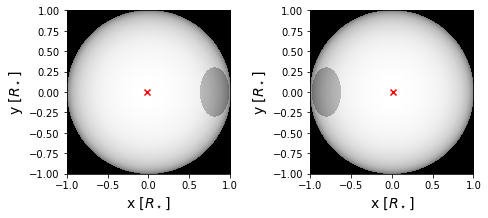

In [2]:
gj1243_t0 = Star()
gj1243_t0.spots = [Spot(x=0.8, y=0.00, r=0.30)]

gj1243_t1 = Star()
gj1243_t1.spots = [Spot(x=-0.8, y=0.00, r=0.30)]

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
gj1243_t0.plot(col=True, ax=ax[0])
gj1243_t1.plot(col=True, ax=ax[1])

In [3]:
photocenters = []

# Measure photocenters as the star rotates
for x in np.linspace(-0.8, 0.8, 50):
    gj1243 = Star()
    gj1243.spots = [Spot(x=x, y=0.00, r=0.30)]
    
    photocenters.append(gj1243.center_of_light)
    
# Measure photocenters as the spot is on the back-side of the star

for x in range(50):
    photocenters.append([0, 0])
    
photocenters = np.array(photocenters)

r_vector = np.sqrt(photocenters[:, 0]**2 + photocenters[:, 1]**2)
std_centroid_shift = np.std(r_vector)

max_centroid_shift = np.max(r_vector)
std_centroid_shift, max_centroid_shift

../mrspoc/star.py:301: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1 - r**2)


(0.00583519524893118, 0.014260235357344194)

(array([ 52.,   4.,   2.,   2.,   4.,   2.,   4.,   4.,   8.,  18.]),
 array([ 0.        ,  0.00142602,  0.00285205,  0.00427807,  0.00570409,
         0.00713012,  0.00855614,  0.00998216,  0.01140819,  0.01283421,
         0.01426024]),
 <a list of 10 Patch objects>)

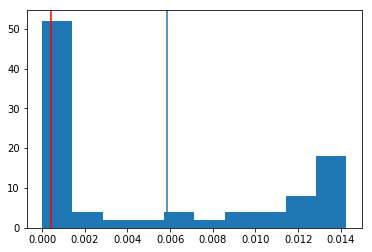

In [4]:
from astropy.stats import mad_std
plt.axvline(np.std(r_vector))
plt.axvline(mad_std(r_vector), color='r')

plt.hist(r_vector)
#plt.xlabel('Jitter [$\mu$AU]')

In [5]:
from mrspoc.tgas import bv_to_radius
R_gj1243 = bv_to_radius(14.47-12.83)
print('Jitter [$\mu$AU] = {}'.format((R_gj1243 * std_centroid_shift).to(u.uAU)))

Jitter [$\mu$AU] = 10.414062968466144 uAU


../mrspoc/tgas.py:89: RuntimeWarning: invalid value encountered in log10
  M_V = Vmag - 5 * (np.log10(dist_pc) + 1)
../mrspoc/tgas.py:168: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(H.T), extent=extent, cmap=plt.cm.Greys, aspect=0.2)


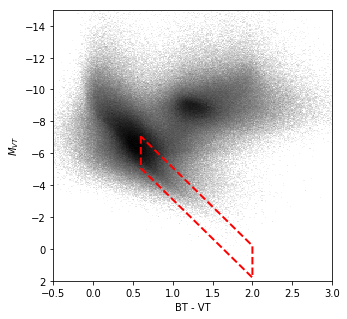

In [6]:
from mrspoc import get_table_ms
from astropy.constants import R_sun
import astropy.units as u

fig, ax = plt.subplots(figsize=(5, 5))
table = get_table_ms(ax=ax, plot=True)
fig.savefig('plots/hr.pdf', bbox_inches='tight')

In [7]:
table['R_star'] = table['R_star'].to(R_sun)

In [8]:
gj1243_teff = 3200 # estimate for sptype = M4
#R_gj1243 = 0.116 # (Mathur+, 2017) 

# Compute the apparent angular jitter due to sunspots at the
# distances of nearby MS stars in the TGAS sample
distances = table['distance']
#R_star = bv_to_radius(table['B-V'].data.data)
R_star = table['R_star']
jitter_rstar = std_centroid_shift * R_star
sigma_jitter = np.arctan((jitter_rstar.quantity/distances.quantity).decompose()).to(u.uarcsec)

# Estimate the single-measurement astrometric error for each star
# in the TGAS sample: 
sigma_gaia = table['sigma_fov']/np.sqrt(table['N_fov'])

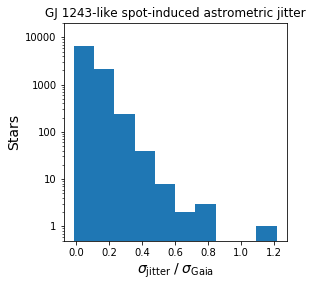

In [17]:
fig, ax = plt.subplots(figsize=(4, 4))

np.save('gj1243_sn.npy', sigma_jitter.value/sigma_gaia.data.data)
ax.hist(sigma_jitter/sigma_gaia, log=True, histtype='stepfilled')
ax.set_title('GJ 1243-like spot-induced astrometric jitter')
ax.set_ylabel('Stars', fontsize=14)
ax.set_xlabel('$\sigma_{\mathrm{jitter}} \; / \; \sigma_{\mathrm{Gaia}}$', fontsize=14)
ax.set_ylim([0.5, 2e4])
y = [1, 10, 100, 1000, 1e4]
ax.set_yticks(y)
ax.set_yticklabels(["{0:g}".format(i) for i in y])
fig.savefig('plots/gj1243_jitter.pdf', bbox_inches='tight')

In [10]:
from astropy.table import Column, join

sig_jit = 'sigma_jitter'
sig_g = 'sigma_gaia'
snr = 'snr'
if sig_jit not in table.colnames:
    table.add_column(Column(data=sigma_jitter, name=sig_jit))
if sig_g not in table.colnames:
    table.add_column(Column(data=sigma_gaia, name=sig_g))
if snr not in table.colnames:
    table.add_column(Column(data=(sigma_jitter/sigma_gaia).decompose(), name=snr))

snr_gtr20 = table[table['snr'] > 1]
print("N stars:", np.count_nonzero(snr_gtr20))

N stars: 1
